In [1]:
import numpy as np
with open('bottle.npy', 'rb') as f:
    bottle = np.load(f, allow_pickle=True)
with open('bottle_2traj.npy', 'rb') as f:
    bottle_2traj = np.load(f, allow_pickle=True)
bottle = bottle[0]
bottle_2traj = bottle_2traj[0]
print(bottle.keys())
print(bottle_2traj.keys())

dict_keys(['robot_state', 'action', 'image', 'task', 'other'])
dict_keys(['robot_state', 'action', 'image', 'task', 'other'])


Data format:  
robot_state: np.ndarray((L, 15))  
[joint0, joint1, joint2, joint3, joint4, joint5, x,y,z, qx,qy,qz,qw, gripper_is_closed, action_blocked]  
action: np.ndarray((L, 8))  
[x, y, z, roll, pitch, yaw, delta_gripper_closed, terminate].  
x, y, z is [-0.02, 0.02], roll, pitch, yaw is [-1/15, 1/15].  
image: np.ndarray((L, 480, 640, 3))  
task: np.ndarray((L, 1))  
other:  
"hand_image": np.ndarray((L, 480, 640, 3)).  
"third_person_image": np.ndarray((L, 480, 640, 4)).  
<!-- 
The data is stored as a Numpy array of trajectories. Each array element is a separate trajectory of length L=250 formatted as a dictionary with the following key and value pairs:

robot_state: np.ndarray((L, 15))
[joint0, joint1, joint2, joint3, joint4, joint5, x,y,z, qx,qy,qz,qw, gripper_is_closed, action_blocked]
x,y,z, qx,qy,qz,qw is the end-effector pose expressed in the robot base frame 
gripper_is_closed is binary: 0 = fully open; 1 = fully closed
action_blocked is binary: 1 if the gripper opening/closing action is being executed and no other actions can be performed; 0 otherwise.

action: np.ndarray((L, 8)) 
[x, y, z, roll, pitch, yaw, delta_gripper_closed, terminate]. Each variable represents the delta change to the dimension value. The delta is with respect to the robot base frame. The range of x, y, z is [-0.02, 0.02], and the range of roll, pitch, yaw is [-1/15, 1/15]. 
delta_gripper_closed is ternary: 1 if gripper closing needs to be triggered from an open state, -1 if gripper opening needs to be triggered from a closed state, 0 if no change. This representation space (0 everywhere except 1 or -1 at 1 or 2 timesteps) could be hard to learn. Preprocessing it to be the action state (0 at the beginning and becomes 1 after the gripper closing action is triggered and keeps at 1 until it becomes 0 when the gripper opening action is triggered) could make the policy easier to learn. Note that the result of such preprocessing will not be equal to the gripper_is_closed key in robot_state as the state has a delay (it takes a few timesteps after the action command is sent before the gripper state actually changes).

image: np.ndarray((L, 480, 640, 3)) the image captured from the robot workspace.
task: np.ndarray((L, 1)) storing the name of the task in natural language.
other:  
"hand_image": np.ndarray((L, 480, 640, 3)).
"third_person_image": np.ndarray((L, 480, 640, 4)). The first 3 channels are the same as "image," and the last dimension is depth.  -->

In [2]:
robot_state = bottle['robot_state']
print(robot_state.shape)
action = bottle['action']
print(action.shape)
image = bottle['image']
print(image.shape)
task = bottle['task']
print(task.shape)
other = bottle['other']
print(other.keys())
hand_image = other['hand_image']
print(hand_image.shape)
third_person_image = other['third_person_image']
print(third_person_image.shape)

(95, 15)
(95, 8)
(95, 480, 640, 3)
(95, 1)
dict_keys(['hand_image', 'third_person_image'])
(95, 480, 640, 3)
(95, 480, 640, 4)


In [13]:
import mediapy
import cv2
# make image 256x256
image_ = np.array([cv2.resize(i, (256, 256)) for i in image])
hand_image_ = np.array([cv2.resize(i, (256, 256)) for i in hand_image])
third_person_image_ = np.array([cv2.resize(i, (256, 256)) for i in third_person_image])
tpi_rgb = third_person_image_[:, :, :, :3]
tpi_rgb = tpi_rgb.astype(np.uint8)
tpi_depth = third_person_image_[:, :, :, 3:]
tpi_depth = tpi_depth/.0 * 255
tpi_depth = tpi_depth.astype(np.uint8)
tpi_depth = np.array([cv2.cvtColor(i, cv2.COLOR_GRAY2BGR) for i in tpi_depth])
#split third_person_image into rgb and depth
print(image_.shape, hand_image_.shape, tpi_rgb.shape, tpi_depth.shape)
# make video [95, 256*4, 256, 3]
video = np.concatenate([image_, hand_image_, tpi_rgb, tpi_depth], axis=2)
print(video.shape)
mediapy.show_video(video, fps=10)

(95, 256, 256, 3) (95, 256, 256, 3) (95, 256, 256, 3) (95, 256, 256, 3)
(95, 256, 1024, 3)


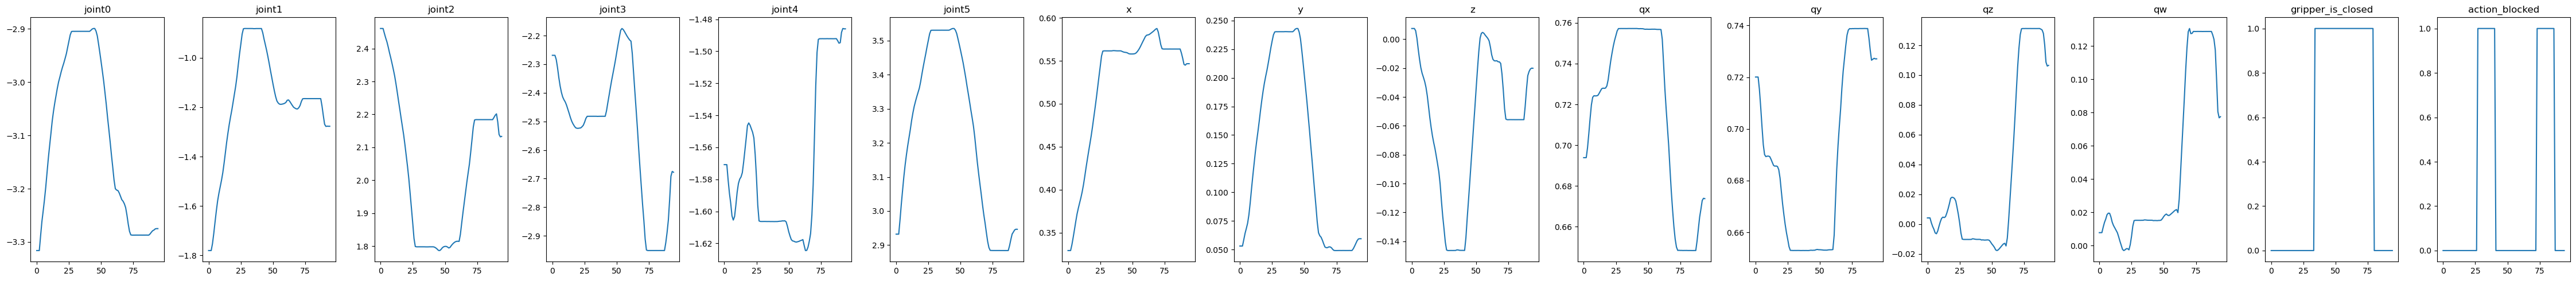

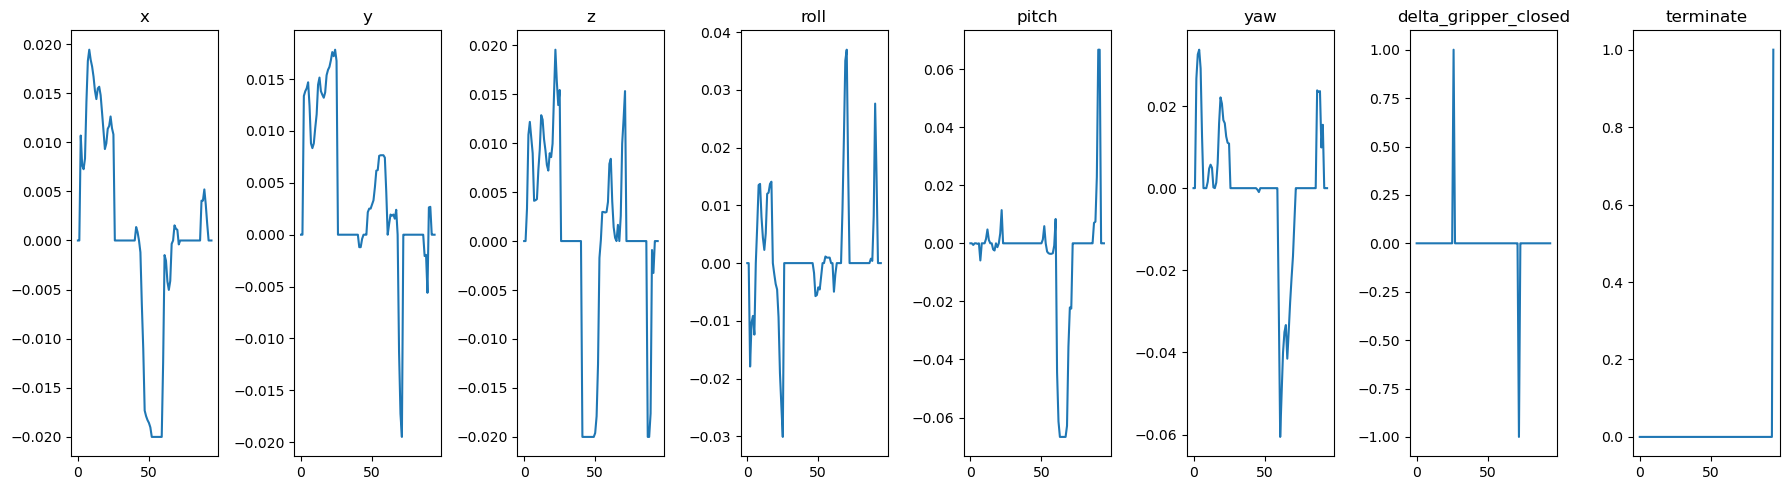

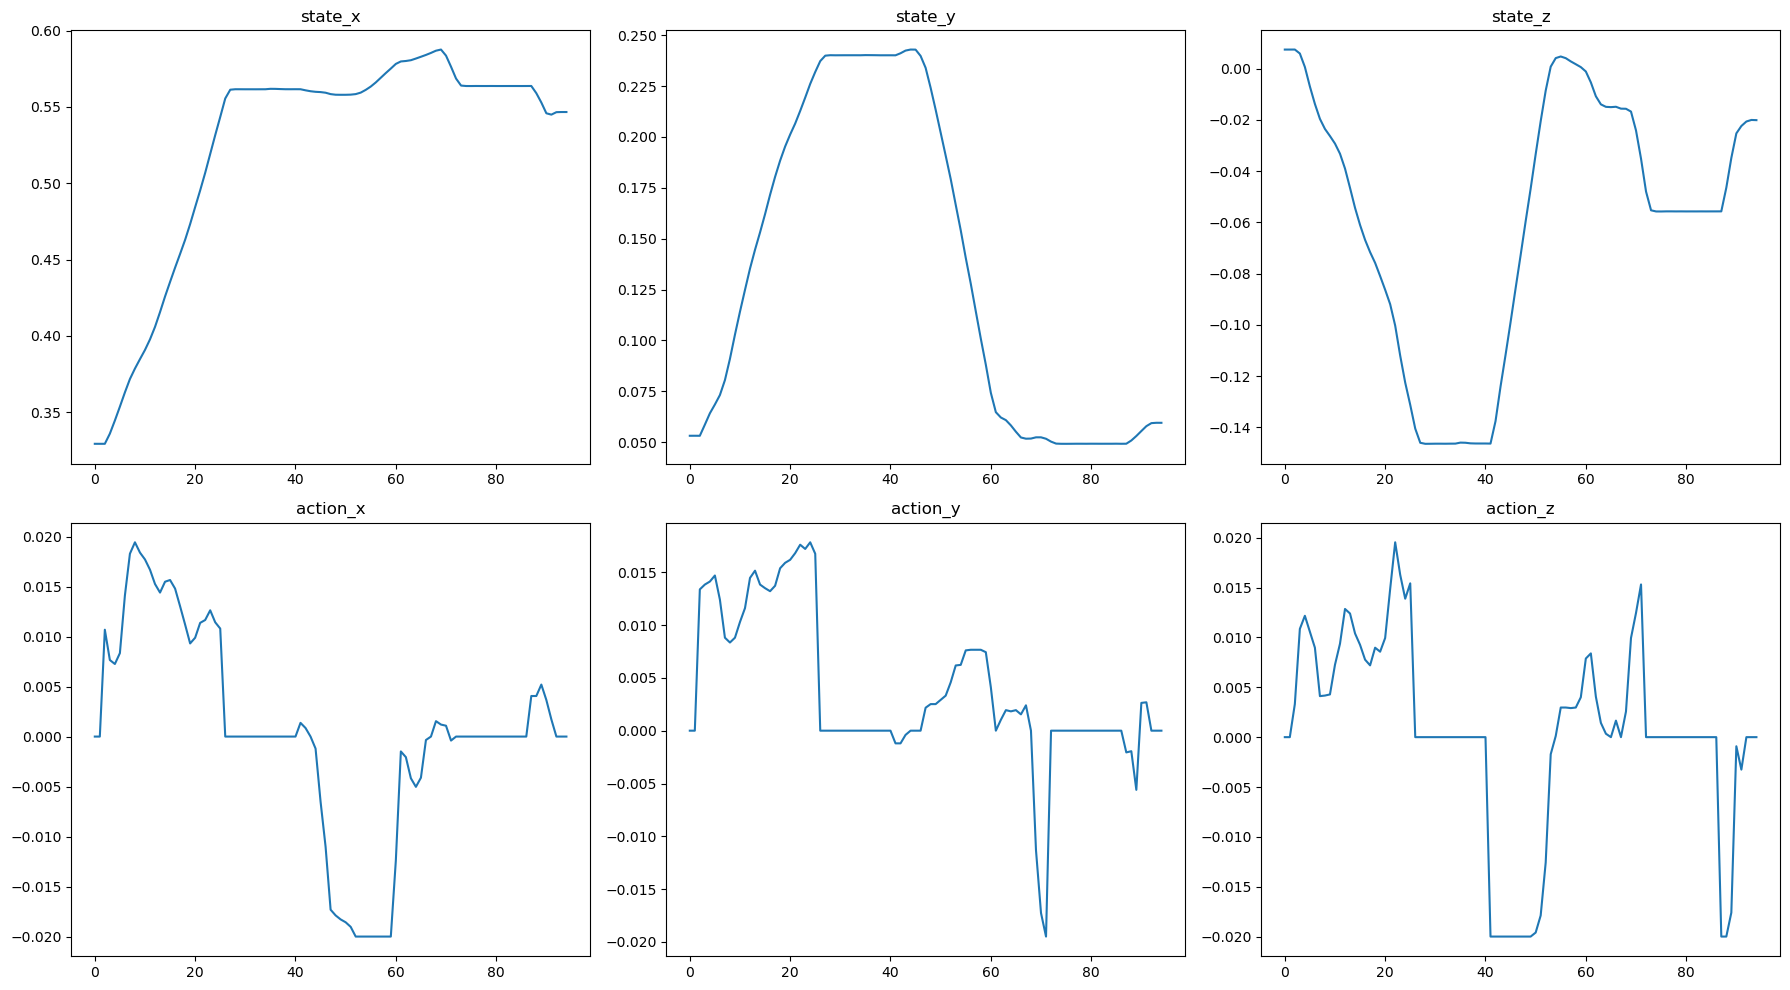

In [17]:
# plot robot_state and action
# robot_state: np.ndarray((L, 15))  
# [joint0, joint1, joint2, joint3, joint4, joint5, x,y,z, qx,qy,qz,qw, gripper_is_closed, action_blocked]  
# action: np.ndarray((L, 8))  
# [x, y, z, roll, pitch, yaw, delta_gripper_closed, terminate].  
robot_state_ = ['joint0', 'joint1', 'joint2', 'joint3', 'joint4', 'joint5', 'x', 'y', 'z', 'qx', 'qy', 'qz', 'qw', 'gripper_is_closed', 'action_blocked']
action_ = ['x', 'y', 'z', 'roll', 'pitch', 'yaw', 'delta_gripper_closed', 'terminate']
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 15, figsize=(45, 5))
for i in range(15):
    axs[i].plot(robot_state[:, i])
    axs[i].set_title(f'{robot_state_[i]}')

fig.tight_layout()
plt.show()

fig, axs = plt.subplots(1, 8, figsize=(18, 5))
for i in range(8):
    axs[i].plot(action[:, i])
    axs[i].set_title(f'{action_[i]}')

fig.tight_layout()
plt.show()

fig, axs = plt.subplots(2, 3, figsize=(18, 10))
axs[0,0].plot(robot_state[:, 6])
axs[0,0].set_title('state_x')
axs[0,1].plot(robot_state[:, 7])
axs[0,1].set_title('state_y')
axs[0,2].plot(robot_state[:, 8])
axs[0,2].set_title('state_z')
axs[1,0].plot(action[:, 0])
axs[1,0].set_title('action_x')
axs[1,1].plot(action[:, 1])
axs[1,1].set_title('action_y')
axs[1,2].plot(action[:, 2])
axs[1,2].set_title('action_z')
fig.tight_layout()
plt.show()
